In [21]:
import graphviz
import sys
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as SkDecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor as SkDecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             RocCurveDisplay, mean_squared_error, mean_absolute_error)

In [22]:
FIGURES_PATH = 'figures'
DICTS_PATH = 'dicts'

In [23]:
class ClassifierNode:
    def __init__(self, feature=None, f_value=None, childs=None, label=None, most_common=None, prob=None):
        # best feature to split the node
        self.feature = feature
        # value of parent's selected feature
        self.f_value = f_value
        # dictionary of childs
        self.childs = childs
        # label of the node if it is leaf
        self.label = label
        # most common label of the node
        self.most_common = most_common
        # probability of positive label
        self.prob = prob
        
        
    def is_leaf_node(self):
        return self.label is not None
    
    def plot_node(self, figure, column_labels, parent=None):
        if self.childs is not None:
            for key in self.childs:
                if not self.childs[key].is_leaf_node():
                    figure.edge(str(column_labels[self.feature]), str(column_labels[self.childs[key].feature]), label=str(key))
                    self.childs[key].plot_node(figure, column_labels)
                else:
                    figure.attr('node', shape='box')
                    figure.edge(str(column_labels[self.feature]), str(self.childs[key].label)+', '+str(column_labels[self.feature]), label=str(key))
                    figure.attr('node', shape='ellipse')
                    
    def node_dict(self, column_labels):
        dict = {}
        if self.is_leaf_node():
            return self.label
        else:
            for key in self.childs:
                dict[str((column_labels[self.feature], self.childs[key].f_value))] = self.childs[key].node_dict(column_labels)
        return dict

In [35]:
class DecisionTreeClassifier:
    def __init__(self, positive_label, criterion='entropy', min_samples_split=1, max_depth=float('inf')):
        # positive label
        self.positive_label = positive_label
        # name of the criterion to select best splits
        self.criterion = criterion
        # minimum number of samples to consider it as leaf
        self.min_samples_split=min_samples_split
        #
        self.max_depth = max_depth
        # root of the tree
        self.root=None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)
    
    def plot_tree(self, column_labels, file_name):
        if not os.path.exists(FIGURES_PATH):
            os.mkdir(FIGURES_PATH)
        path = os.path.join(FIGURES_PATH, file_name)
        
        figure = graphviz.Digraph(file_name, filename=path)
        figure.attr('node', shape='ellipse')
        self.root.plot_node(figure, column_labels)
        figure.view()
        
    def save_dict(self, column_labels, file_name):
        dict = self.root.node_dict(column_labels)
        if not os.path.exists(DICTS_PATH):
            os.mkdir(DICTS_PATH)
        path = os.path.join(DICTS_PATH, file_name+'.txt')
        with open(path, 'w') as file:
            print(json.dumps(dict, indent=4), file=file)
        

    def _grow_tree(self, X, y, f_value=None, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (n_labels == 1 or n_samples < self.min_samples_split or depth >= self.max_depth):
            leaf_value, leaf_prob = self._most_common_label(y)
            return ClassifierNode(f_value=f_value, label=leaf_value, most_common=leaf_value, prob=leaf_prob)

        # find the best split
        best_feature = self._best_split(X, y)

        # create child nodes
        childs = {}
        best_feature_column = X[:, best_feature]
        for v in np.unique(best_feature_column):
            index = np.argwhere(best_feature_column == v).flatten()
            child_X = X[index]
            child_y = y[index]
            childs[v] = self._grow_tree(child_X, child_y, v, depth=depth+1)
        
        leaf_value, leaf_prob = self._most_common_label(y)
        return ClassifierNode(feature=best_feature, f_value=f_value, childs=childs, most_common=leaf_value, prob=leaf_prob)


    def _best_split(self, X, y):
        if self.criterion == 'entropy':
            best_gain = -1
            split_idx = None
            for feat_idx in range(X.shape[1]):
                X_column = X[:, feat_idx]
                gain = self._information_gain(y, X_column)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
            return split_idx
        
        elif self.criterion == 'gini':
            best_gini = float('inf')
            split_idx = None
            for feat_idx in range(X.shape[1]):
                X_column = X[:, feat_idx]
                gini = self._gini_split(y, X_column)
                if gini < best_gini:
                    best_gini = gini
                    split_idx = feat_idx
            return split_idx

    def _information_gain(self, y, X_column):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        childs_idx = self._split(X_column)
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        information_gain = parent_entropy
        for ch_id in childs_idx:
            n_ch = len(ch_id)
            information_gain -= (n_ch / n) * self._entropy(y[ch_id])
            
        return information_gain

    def _split(self, X_column):
        splits = []
        for v in np.unique(X_column):
            splits.append(np.argwhere(X_column == v).flatten())
        return splits

    def _entropy(self, y):
        count = Counter(y)
        return -np.sum([count[i]/len(y) * np.log2(count[i]/len(y)) for i in count])

    def _gini_split(self, y, X_column):
        # create children
        childs_idx = self._split(X_column)
        # calculate Gini split
        n = len(y)
        return np.sum([(len(ch_id)/n) * self._gini_index(y[ch_id]) for ch_id in childs_idx])
            
    
    def _gini_index(self, y):
        count = Counter(y)
        return 1 - np.sum([(count[i]/len(y)) ** 2 for i in count])
    
    
    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        positive_label_prob = counter[self.positive_label] / len(y)
        return value, positive_label_prob

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def predict_prob(self, X):
        return np.array([self._traverse_tree_prob(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.label
        
        if x[node.feature] in node.childs:
            return self._traverse_tree(x, node.childs[x[node.feature]])
        else:
            return node.most_common
        
    def _traverse_tree_prob(self, x, node):
        if node.is_leaf_node():
            return node.prob
        
        if x[node.feature] in node.childs:
            return self._traverse_tree_prob(x, node.childs[x[node.feature]])
        else:
            return node.prob

In [25]:
def classification_evaluation(y_pred, y, pos_label, y_pred_prob):
    acc = accuracy_score(y_pred, y)
    prec = precision_score(y_pred, y, pos_label=pos_label)
    rec = recall_score(y_pred, y, pos_label=pos_label)
    f1 = f1_score(y_pred, y, pos_label=pos_label)
    
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    
    print(f'Accuracy={round(acc, ndigits=4)}, Precision={round(prec, ndigits=4)}, Recall={round(rec, ndigits=4)}, F1={round(f1, ndigits=4)}')
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    disp.plot(ax=ax[0])
    RocCurveDisplay.from_predictions(np.where(y == pos_label, 1, 0), y_pred_prob, ax=ax[1])
    plt.show()

# Restaurant dataset

In [210]:
data = {
    'alt': ['Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes'],
    'bar': ['No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes'],
    'fri': ['No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes'],
    'hun': ['Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes'],
    'pat': ['Some', 'Full', 'Some', 'Full', 'Full', 'Some', 'None', 'Some', 'Full', 'Full', 'None', 'Full'],
    'price': ['$$$', '$', '$', '$', '$$$', '$$', '$', '$$', '$', '$$$', '$', '$'],
    'rain': ['No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No'],
    'res': ['Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No'],
    'type': ['French', 'Thai', 'Burger', 'Thai', 'French', 'Italian', 'Burger', 'Thai', 'Burger', 'Italian', 'Thai', 'Burger'],
    'est': ['0-10', '30-60', '0-10', '10-30', '>60', '0-10', '0-10', '0-10', '>60', '10-30', '0-10', '30-60'],
    'will_wait': ['Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'Yes']
}
df = pd.DataFrame(data)
POS_LABEL = 'Yes'
df

,alt,bar,fri,hun,pat,price,rain,res,type,est,will_wait
0,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,Yes
1,Yes,No,No,Yes,Full,$,No,No,Thai,30-60,No
2,No,Yes,No,No,Some,$,No,No,Burger,0-10,Yes
3,Yes,No,Yes,Yes,Full,$,Yes,No,Thai,10-30,Yes
4,Yes,No,Yes,No,Full,$$$,No,Yes,French,>60,No
5,No,Yes,No,Yes,Some,$$,Yes,Yes,Italian,0-10,Yes
6,No,Yes,No,No,None,$,Yes,No,Burger,0-10,No
7,No,No,No,Yes,Some,$$,Yes,Yes,Thai,0-10,Yes
8,No,Yes,Yes,No,Full,$,Yes,No,Burger,>60,No
9,Yes,Yes,Yes,Yes,Full,$$$,No,Yes,Italian,10-30,No


In [211]:
tree = DecisionTreeClassifier(positive_label=POS_LABEL, criterion='gini')
tree.fit(df.to_numpy()[:, :-1], df.to_numpy()[:, -1])

tree.plot_tree(list(df.columns), 'restaurant')
tree.save_dict(list(df.columns), file_name='restaurant')

# Cancer dataset

In [26]:
df = pd.read_csv('part2.csv').iloc[:, 1:-1]
POS_LABEL = 'M'
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


# Using `cut`

### `entropy` criterion

TRAIN with 5 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


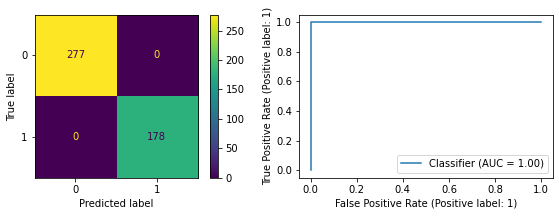

TEST with 5 bins ---------------------------------------------------------
Accuracy=0.9211, Precision=0.9706, Recall=0.8049, F1=0.88


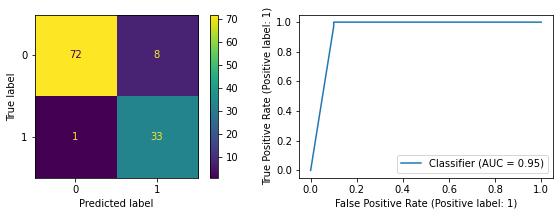

TRAIN with 10 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


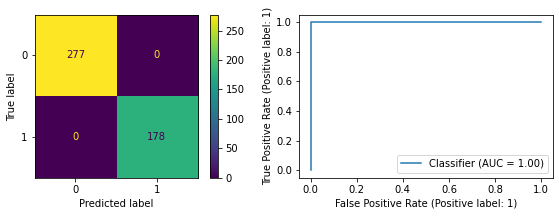

TEST with 10 bins ---------------------------------------------------------
Accuracy=0.8684, Precision=0.8824, Recall=0.7317, F1=0.8


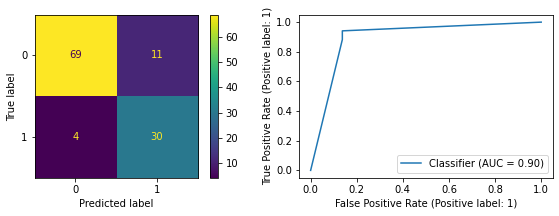

TRAIN with 15 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


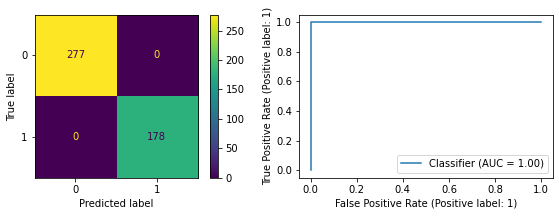

TEST with 15 bins ---------------------------------------------------------
Accuracy=0.9211, Precision=0.9118, Recall=0.8378, F1=0.8732


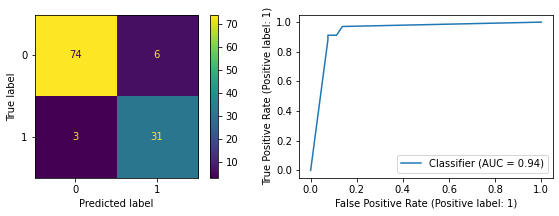

TRAIN with 20 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


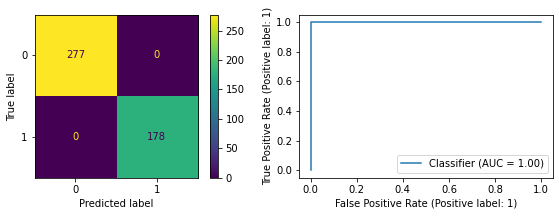

TEST with 20 bins ---------------------------------------------------------
Accuracy=0.8684, Precision=0.8235, Recall=0.7568, F1=0.7887


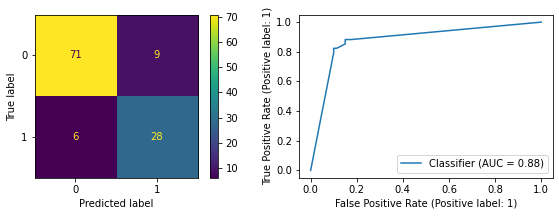

TRAIN with 30 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


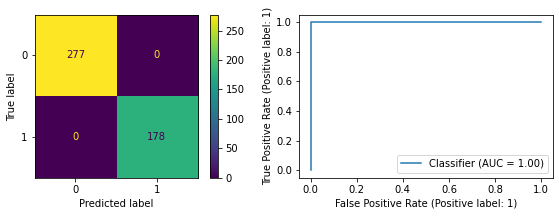

TEST with 30 bins ---------------------------------------------------------
Accuracy=0.886, Precision=0.8529, Recall=0.7838, F1=0.8169


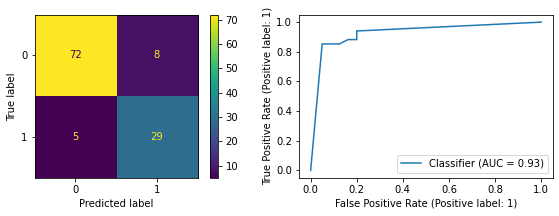

TRAIN with 50 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


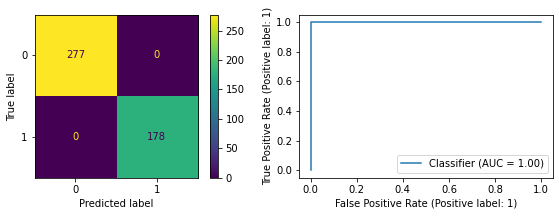

TEST with 50 bins ---------------------------------------------------------
Accuracy=0.8596, Precision=0.8235, Recall=0.7368, F1=0.7778


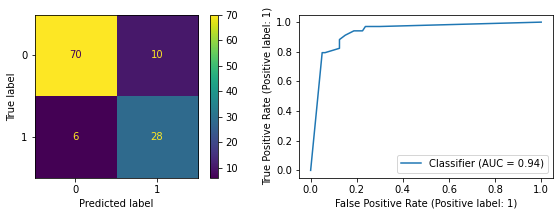

Maximum accuracy 0.9210526315789473 with 5 bins


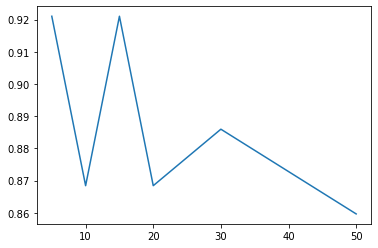

In [27]:
values = [5, 10, 15, 20, 30, 50]
acc_history = []

for v in values:
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    bins = []
    for c in x_train.columns:
        x_train[c], c_bins = pd.cut(x_train[c], v, retbins=True)
        bins.append(c_bins)

    my_tree = DecisionTreeClassifier(positive_label=POS_LABEL)
    my_tree.fit(x_train.to_numpy(), y_train.to_numpy())
    
    my_tree.plot_tree(list(x_train.columns), 'cancer_cut_entropy'+str(v)+'bins')
    my_tree.save_dict(list(x_train.columns), 'cancer_cut_entropy'+str(v)+'bins')
    
    for idx, c in enumerate(x_test.columns):
        x_test[c] = pd.cut(x_test[c], bins[idx])
    
    print(f'TRAIN with {v} bins --------------------------------------------------------')
    y_pred = my_tree.predict(x_train.to_numpy())
    y_pred_prob = my_tree.predict_prob(x_train.to_numpy())
    classification_evaluation(y_pred, y_train, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)
    
    print(f'TEST with {v} bins ---------------------------------------------------------')
    y_pred = my_tree.predict(x_test.to_numpy())
    y_pred_prob = my_tree.predict_prob(x_test.to_numpy())
    classification_evaluation(y_pred, y_test, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)
    acc_history.append(accuracy_score(y_pred, y_test.to_numpy()))

print(f'Maximum accuracy {np.max(acc_history)} with {values[np.argmax(acc_history)]} bins')
plt.plot(values, acc_history)

### `gini` criterion

TRAIN with 5 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


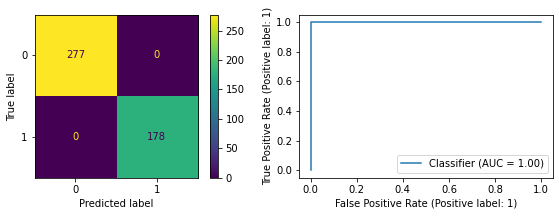

TEST with 5 bins ---------------------------------------------------------
Accuracy=0.9211, Precision=0.9706, Recall=0.8049, F1=0.88


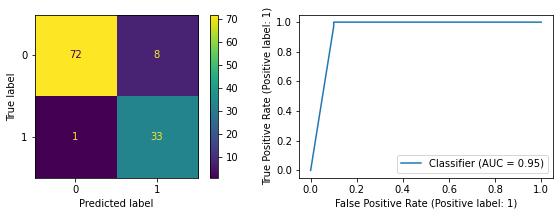

TRAIN with 10 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


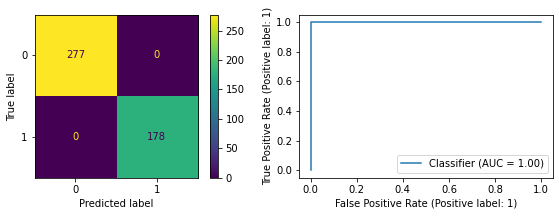

TEST with 10 bins ---------------------------------------------------------
Accuracy=0.8684, Precision=0.8824, Recall=0.7317, F1=0.8


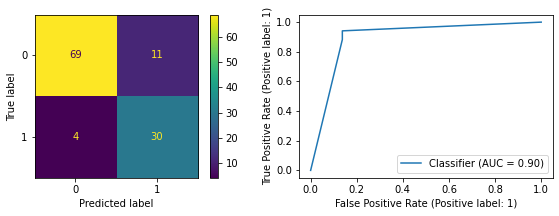

TRAIN with 15 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


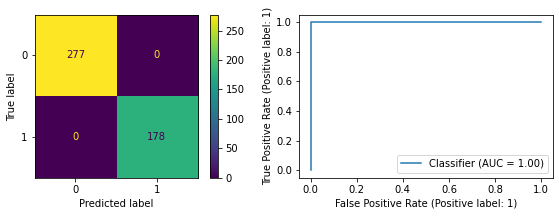

TEST with 15 bins ---------------------------------------------------------
Accuracy=0.8684, Precision=0.8824, Recall=0.7317, F1=0.8


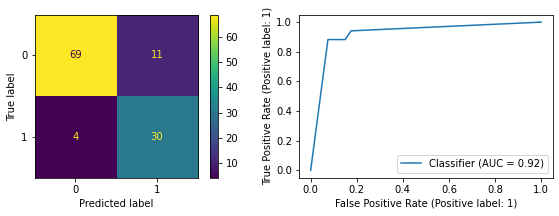

TRAIN with 20 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


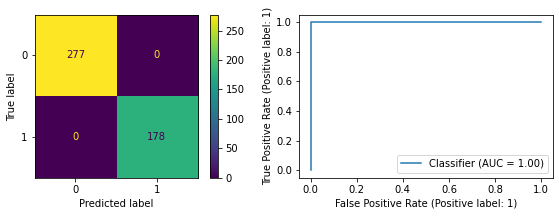

TEST with 20 bins ---------------------------------------------------------
Accuracy=0.8684, Precision=0.8235, Recall=0.7568, F1=0.7887


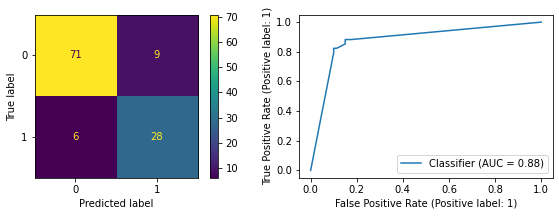

TRAIN with 30 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


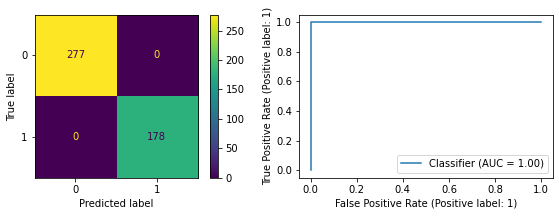

TEST with 30 bins ---------------------------------------------------------
Accuracy=0.886, Precision=0.8529, Recall=0.7838, F1=0.8169


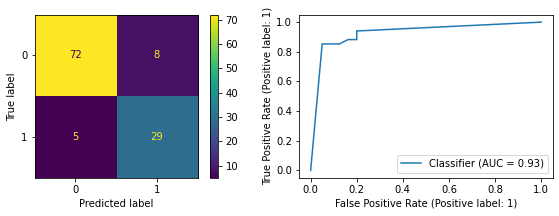

TRAIN with 50 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


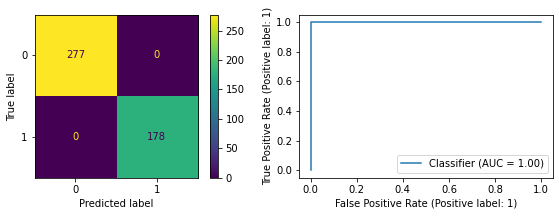

TEST with 50 bins ---------------------------------------------------------
Accuracy=0.8596, Precision=0.8235, Recall=0.7368, F1=0.7778


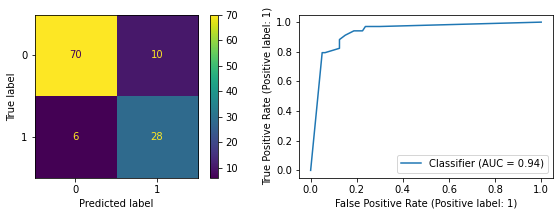

Maximum accuracy 0.9210526315789473 with 5 bins


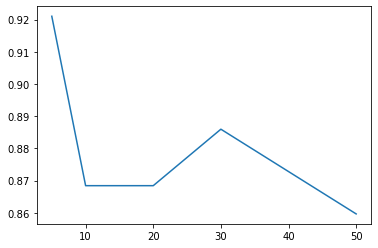

In [214]:
values = [5, 10, 15, 20, 30, 50]
acc_history = []

for v in values:
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    bins = []
    for c in x_train.columns:
        x_train[c], c_bins = pd.cut(x_train[c], v, retbins=True)
        bins.append(c_bins)

    my_tree = DecisionTreeClassifier(positive_label=POS_LABEL, criterion='gini')
    my_tree.fit(x_train.to_numpy(), y_train.to_numpy())
    
    my_tree.plot_tree(list(x_train.columns), 'cancer_cut_gini'+str(v)+'bins')
    my_tree.save_dict(list(x_train.columns), 'cancer_cut_gini'+str(v)+'bins')
    
    for idx, c in enumerate(x_test.columns):
        x_test[c] = pd.cut(x_test[c], bins[idx])
        
    print(f'TRAIN with {v} bins --------------------------------------------------------')
    y_pred = my_tree.predict(x_train.to_numpy())
    y_pred_prob = my_tree.predict_prob(x_train.to_numpy())
    classification_evaluation(y_pred, y_train, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)
    
    print(f'TEST with {v} bins ---------------------------------------------------------')
    y_pred = my_tree.predict(x_test.to_numpy())
    y_pred_prob = my_tree.predict_prob(x_test.to_numpy())
    classification_evaluation(y_pred, y_test, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)
    acc_history.append(accuracy_score(y_pred, y_test.to_numpy()))

print(f'Maximum accuracy {np.max(acc_history)} with {values[np.argmax(acc_history)]} bins')
plt.plot(values, acc_history)

In [215]:
BEST_BIN_CUT = 5

# Using `qcut`

### `entropy` criterion

TRAIN with 5 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


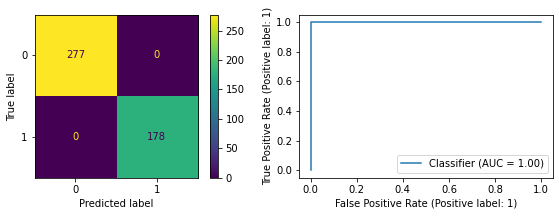

TEST with 5 bins ---------------------------------------------------------
Accuracy=0.886, Precision=1.0, Recall=0.7234, F1=0.8395


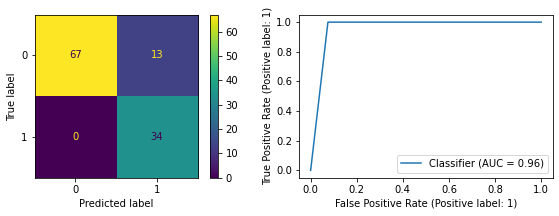

TRAIN with 10 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


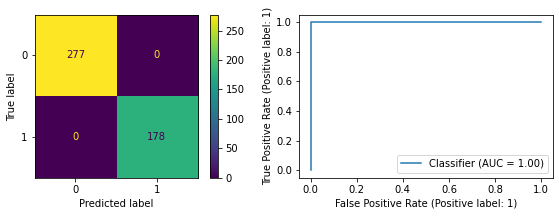

TEST with 10 bins ---------------------------------------------------------
Accuracy=0.9386, Precision=0.8824, Recall=0.9091, F1=0.8955


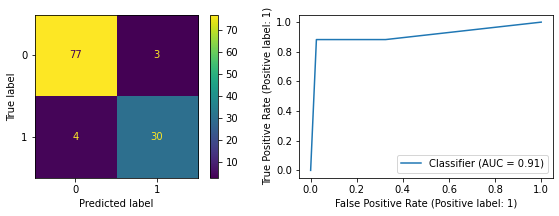

TRAIN with 15 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


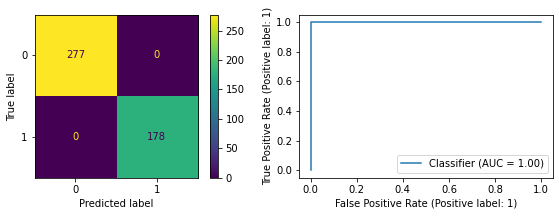

TEST with 15 bins ---------------------------------------------------------
Accuracy=0.8772, Precision=0.8529, Recall=0.7632, F1=0.8056


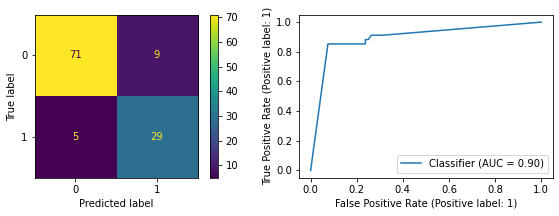

TRAIN with 20 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


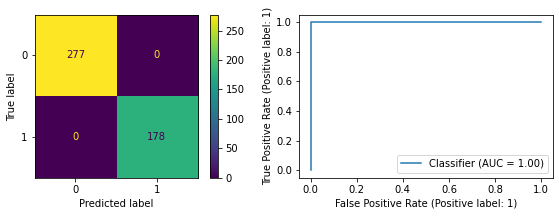

TEST with 20 bins ---------------------------------------------------------
Accuracy=0.886, Precision=0.8529, Recall=0.7838, F1=0.8169


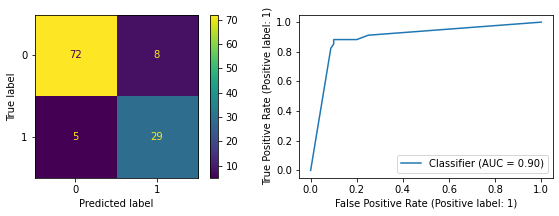

TRAIN with 30 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


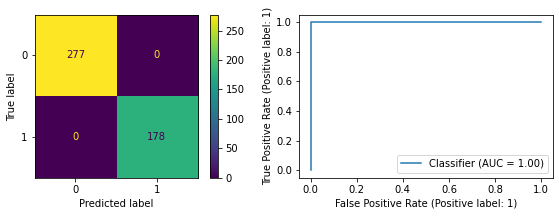

TEST with 30 bins ---------------------------------------------------------
Accuracy=0.8421, Precision=0.8824, Recall=0.6818, F1=0.7692


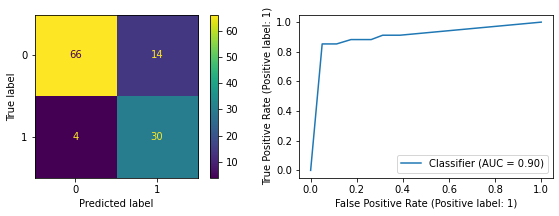

TRAIN with 50 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


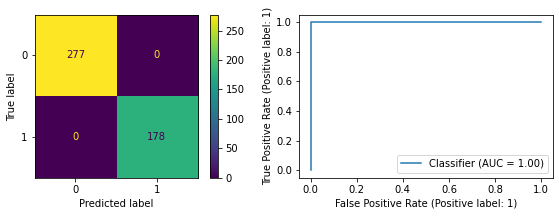

TEST with 50 bins ---------------------------------------------------------
Accuracy=0.8421, Precision=0.8824, Recall=0.6818, F1=0.7692


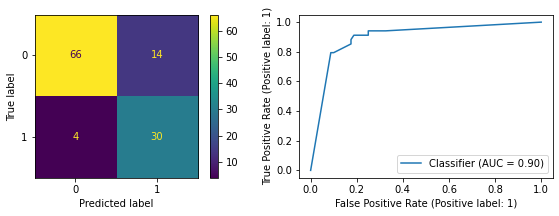

Maximum accuracy 0.9385964912280702 with 10 bins


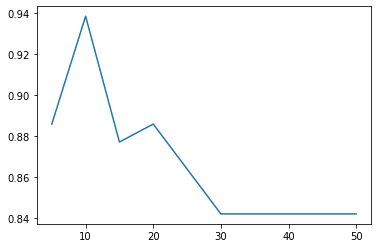

In [216]:
values = [5, 10, 15, 20, 30, 50]
acc_history = []

for v in values:
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    bins = []
    for c in x_train.columns:
        x_train[c], c_bins = pd.qcut(x_train[c], v, retbins=True)
        bins.append(c_bins)

    my_tree = DecisionTreeClassifier(positive_label=POS_LABEL)
    my_tree.fit(x_train.to_numpy(), y_train.to_numpy())
    
    my_tree.plot_tree(list(x_train.columns), 'cancer_qcut_entropy'+str(v)+'bins')
    my_tree.save_dict(list(x_train.columns), 'cancer_qcut_entropy'+str(v)+'bins')
    
    for idx, c in enumerate(x_test.columns):
        x_test[c] = pd.cut(x_test[c], bins[idx])
        
    print(f'TRAIN with {v} bins --------------------------------------------------------')
    y_pred = my_tree.predict(x_train.to_numpy())
    y_pred_prob = my_tree.predict_prob(x_train.to_numpy())
    classification_evaluation(y_pred, y_train, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)
    
    print(f'TEST with {v} bins ---------------------------------------------------------')
    y_pred = my_tree.predict(x_test.to_numpy())
    y_pred_prob = my_tree.predict_prob(x_test.to_numpy())
    classification_evaluation(y_pred, y_test, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)
    acc_history.append(accuracy_score(y_pred, y_test.to_numpy()))
    
print(f'Maximum accuracy {np.max(acc_history)} with {values[np.argmax(acc_history)]} bins')
plt.plot(values, acc_history)

### `gini` criterion

TRAIN with 5 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


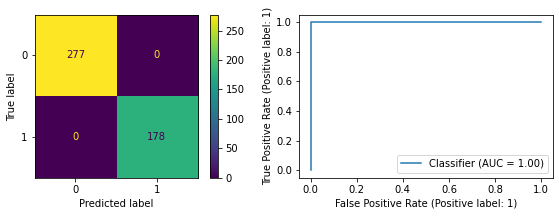

TEST with 5 bins ---------------------------------------------------------
Accuracy=0.8947, Precision=1.0, Recall=0.7391, F1=0.85


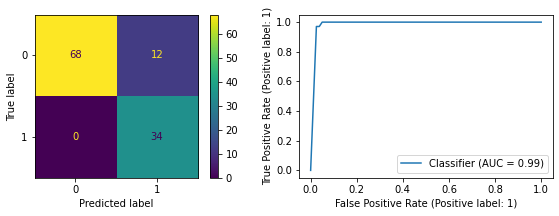

TRAIN with 10 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


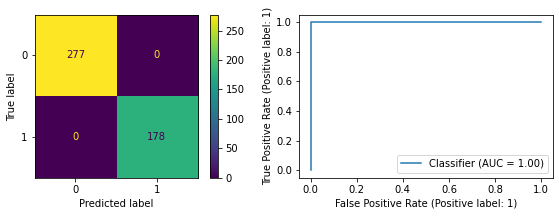

TEST with 10 bins ---------------------------------------------------------
Accuracy=0.9386, Precision=0.8824, Recall=0.9091, F1=0.8955


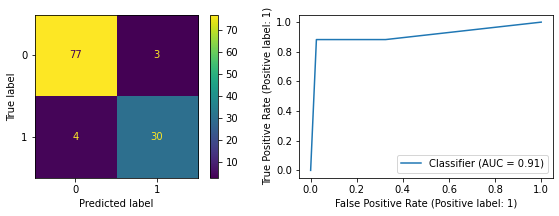

TRAIN with 15 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


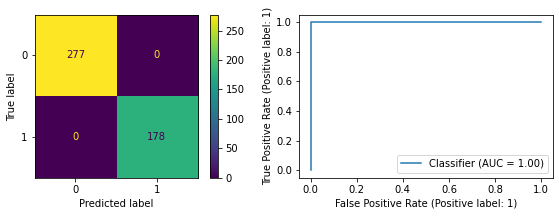

TEST with 15 bins ---------------------------------------------------------
Accuracy=0.8772, Precision=0.8529, Recall=0.7632, F1=0.8056


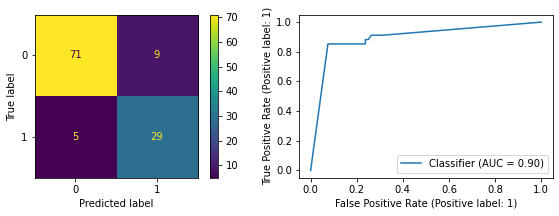

TRAIN with 20 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


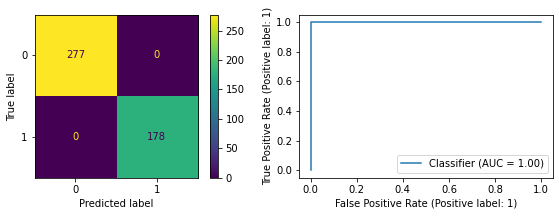

TEST with 20 bins ---------------------------------------------------------
Accuracy=0.886, Precision=0.8529, Recall=0.7838, F1=0.8169


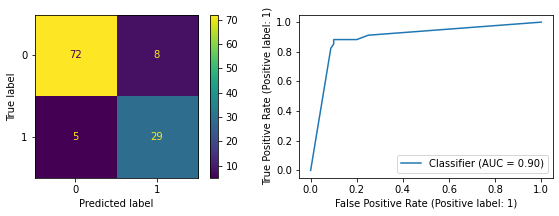

TRAIN with 30 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


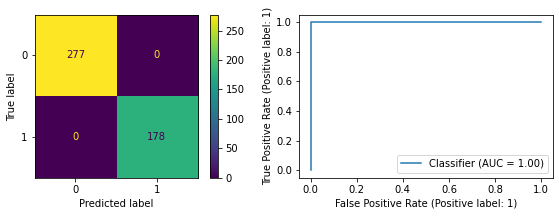

TEST with 30 bins ---------------------------------------------------------
Accuracy=0.8421, Precision=0.8824, Recall=0.6818, F1=0.7692


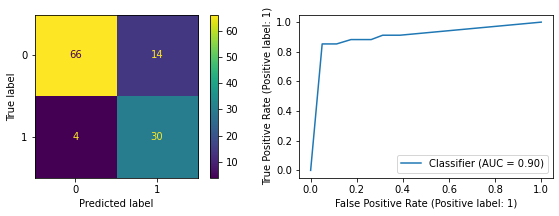

TRAIN with 50 bins --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


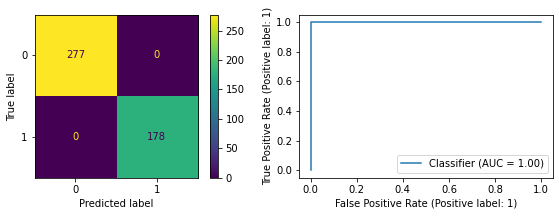

TEST with 50 bins ---------------------------------------------------------
Accuracy=0.8421, Precision=0.8824, Recall=0.6818, F1=0.7692


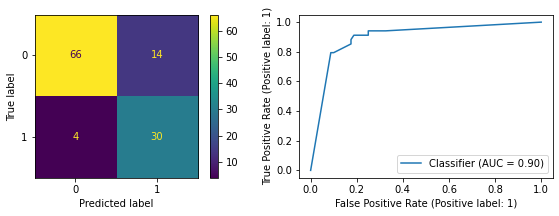

Maximum accuracy 0.9385964912280702 with 10 bins


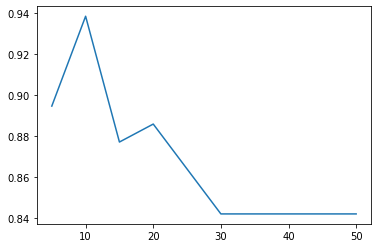

In [217]:
values = [5, 10, 15, 20, 30, 50]
acc_history = []

for v in values:
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    bins = []
    for c in x_train.columns:
        x_train[c], c_bins = pd.qcut(x_train[c], v, retbins=True)
        bins.append(c_bins)

    my_tree = DecisionTreeClassifier(positive_label=POS_LABEL, criterion='gini')
    my_tree.fit(x_train.to_numpy(), y_train.to_numpy())
    
    my_tree.plot_tree(list(x_train.columns), 'cancer_qcut_gini'+str(v)+'bins')
    my_tree.save_dict(list(x_train.columns), 'cancer_qcut_gini'+str(v)+'bins')
    
    for idx, c in enumerate(x_test.columns):
        x_test[c] = pd.cut(x_test[c], bins[idx])
        
    print(f'TRAIN with {v} bins --------------------------------------------------------')
    y_pred = my_tree.predict(x_train.to_numpy())
    y_pred_prob = my_tree.predict_prob(x_train.to_numpy())
    classification_evaluation(y_pred, y_train, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)
    
    print(f'TEST with {v} bins ---------------------------------------------------------')
    y_pred = my_tree.predict(x_test.to_numpy())
    y_pred_prob = my_tree.predict_prob(x_test.to_numpy())
    classification_evaluation(y_pred, y_test, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)
    acc_history.append(accuracy_score(y_pred, y_test.to_numpy()))
    
print(f'Maximum accuracy {np.max(acc_history)} with {values[np.argmax(acc_history)]} bins')
plt.plot(values, acc_history)

In [28]:
BEST_BIN_QCUT = 10

# Using sort and cut algorithm

In [107]:
def sort_cut(column, label):
    bins = []
    array = np.stack([column, label]).T
    array = array[array[:, 0].argsort()]
    bins.append(array[0, 0] - 1e-10)
    current_class = array[0, 1]
    for i in range(1, array.shape[0]):
        if array[i, 1] != current_class:
            bins.append((array[i, 0] + array[i - 1, 0]) / 2)
            current_class = array[i, 1]
    bins.append(array[-1, 0] + 1e-10)
    bins = np.unique(bins)
    return bins

### `entropy` criterion

TRAIN --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


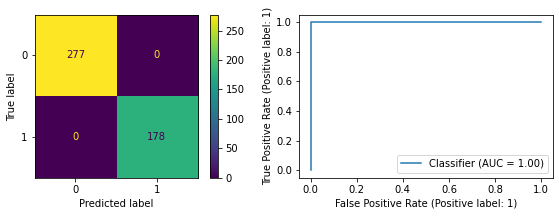

TEST ---------------------------------------------------------
Accuracy=0.8684, Precision=0.8824, Recall=0.7317, F1=0.8


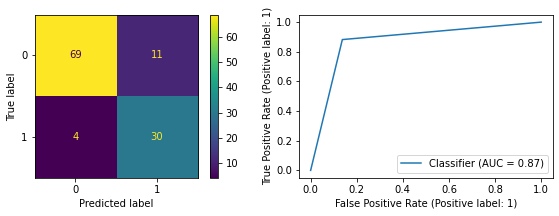

In [219]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

bins = []
for c in x_train.columns:
    bins.append(sort_cut(x_train[c], y_train))
    x_train[c] = pd.cut(x_train[c], bins[-1])

my_tree = DecisionTreeClassifier(positive_label=POS_LABEL)
my_tree.fit(x_train.to_numpy(), y_train.to_numpy())

my_tree.plot_tree(list(x_train.columns), 'cancer_sortcut_entropy')
my_tree.save_dict(list(x_train.columns), 'cancer_sortcut_entropy')

for idx, c in enumerate(x_test.columns):
    x_test[c] = pd.cut(x_test[c], bins[idx])

print(f'TRAIN --------------------------------------------------------')
y_pred = my_tree.predict(x_train.to_numpy())
y_pred_prob = my_tree.predict_prob(x_train.to_numpy())
classification_evaluation(y_pred, y_train, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)

print(f'TEST ---------------------------------------------------------')
y_pred = my_tree.predict(x_test.to_numpy())
y_pred_prob = my_tree.predict_prob(x_test.to_numpy())
classification_evaluation(y_pred, y_test, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)

### `gini` criterion

TRAIN --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


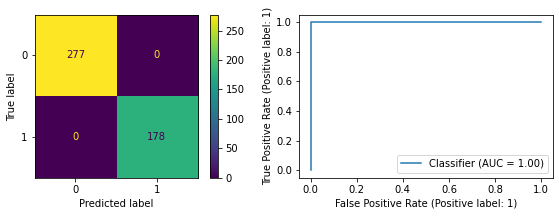

TEST ---------------------------------------------------------
Accuracy=0.8684, Precision=0.8824, Recall=0.7317, F1=0.8


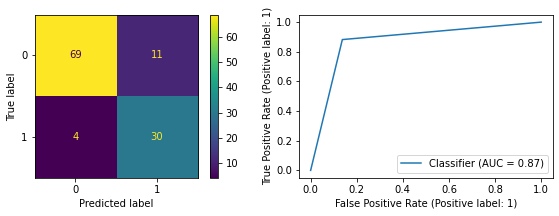

In [220]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

bins = []
for c in x_train.columns:
    bins.append(sort_cut(x_train[c], y_train))
    x_train[c] = pd.cut(x_train[c], bins[-1])

my_tree = DecisionTreeClassifier(positive_label=POS_LABEL, criterion='gini')
my_tree.fit(x_train.to_numpy(), y_train.to_numpy())

my_tree.plot_tree(list(x_train.columns), 'cancer_sortcut_gini')
my_tree.save_dict(list(x_train.columns), 'cancer_sortcut_gini')

for idx, c in enumerate(x_test.columns):
    x_test[c] = pd.cut(x_test[c], bins[idx])

print(f'TRAIN --------------------------------------------------------')
y_pred = my_tree.predict(x_train.to_numpy())
y_pred_prob = my_tree.predict_prob(x_train.to_numpy())
classification_evaluation(y_pred, y_train, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)

print(f'TEST ---------------------------------------------------------')
y_pred = my_tree.predict(x_test.to_numpy())
y_pred_prob = my_tree.predict_prob(x_test.to_numpy())
classification_evaluation(y_pred, y_test, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)

# Sklearn results

### `entropy` criterion

TRAIN --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


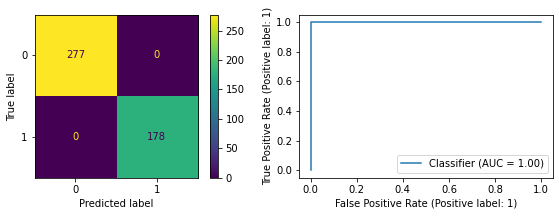

TEST ---------------------------------------------------------
Accuracy=0.886, Precision=0.9412, Recall=0.7442, F1=0.8312


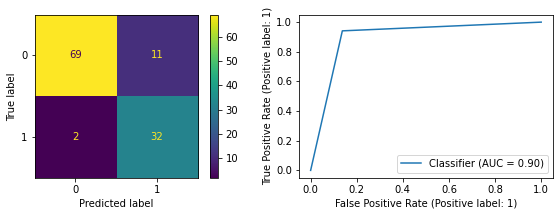

In [18]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]
    
x_train, x_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, random_state=4)

sk_tree = SkDecisionTreeClassifier(criterion='entropy')
sk_tree.fit(x_train, y_train)

print(f'TRAIN --------------------------------------------------------')
y_pred = sk_tree.predict(x_train)
y_pred_prob = sk_tree.predict_proba(x_train)
# print(y_pred_prob)
classification_evaluation(y_pred, y_train, pos_label=POS_LABEL, y_pred_prob=y_pred_prob[:, np.where(sk_tree.classes_ == POS_LABEL)].reshape(-1))

print(f'TEST ---------------------------------------------------------')
y_pred = sk_tree.predict(x_test)
y_pred_prob = sk_tree.predict_proba(x_test)
classification_evaluation(y_pred, y_test, pos_label=POS_LABEL, y_pred_prob=y_pred_prob[:, np.where(sk_tree.classes_ == POS_LABEL)].reshape(-1))

### `gini` criterion

TRAIN --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


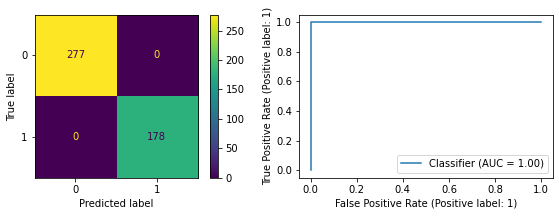

TEST ---------------------------------------------------------
Accuracy=0.8947, Precision=1.0, Recall=0.7391, F1=0.85


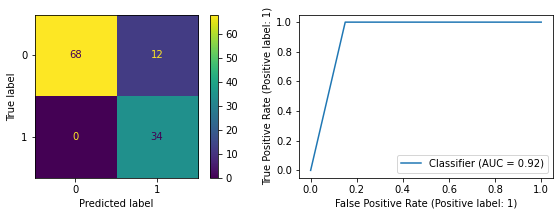

In [19]:
sk_tree = SkDecisionTreeClassifier(criterion='gini')
sk_tree.fit(x_train, y_train)

print(f'TRAIN --------------------------------------------------------')
y_pred = sk_tree.predict(x_train)
y_pred_prob = sk_tree.predict_proba(x_train)
# print(y_pred_prob)
classification_evaluation(y_pred, y_train, pos_label=POS_LABEL, y_pred_prob=y_pred_prob[:, np.where(sk_tree.classes_ == POS_LABEL)].reshape(-1))

print(f'TEST ---------------------------------------------------------')
y_pred = sk_tree.predict(x_test)
y_pred_prob = sk_tree.predict_proba(x_test)
classification_evaluation(y_pred, y_test, pos_label=POS_LABEL, y_pred_prob=y_pred_prob[:, np.where(sk_tree.classes_ == POS_LABEL)].reshape(-1))

# Dimension reduction using PCA
`qcut` discretization method used with best bin which calculated in previous steps.

### `entropy` criterion

TRAIN --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


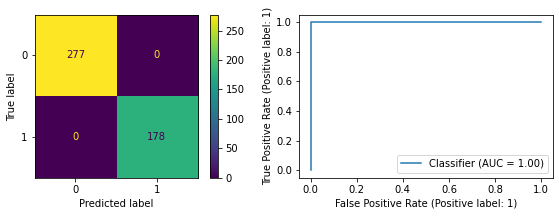

TEST ---------------------------------------------------------
Accuracy=0.9123, Precision=0.8529, Recall=0.8529, F1=0.8529


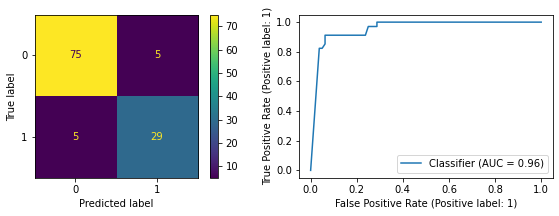

In [221]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

pca = PCA(n_components=10, random_state=4)
x_train = pd.DataFrame(pca.fit_transform(x_train))

bins = []
for c in x_train.columns:
    x_train[c], c_bins = pd.qcut(x_train[c], BEST_BIN_QCUT, retbins=True)
    bins.append(c_bins)

my_tree = DecisionTreeClassifier(positive_label=POS_LABEL)
my_tree.fit(x_train.to_numpy(), y_train.to_numpy())

my_tree.plot_tree(list(x_train.columns), 'cancer_qcut_entropy_pca')
my_tree.save_dict(list(x_train.columns), 'cancer_qcut_entropy_pca')

x_test = pd.DataFrame(pca.transform(x_test))
for idx, c in enumerate(x_test.columns):
    x_test[c] = pd.cut(x_test[c], bins[idx])

print(f'TRAIN --------------------------------------------------------')
y_pred = my_tree.predict(x_train.to_numpy())
y_pred_prob = my_tree.predict_prob(x_train.to_numpy())
classification_evaluation(y_pred, y_train, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)

print(f'TEST ---------------------------------------------------------')
y_pred = my_tree.predict(x_test.to_numpy())
y_pred_prob = my_tree.predict_prob(x_test.to_numpy())
classification_evaluation(y_pred, y_test, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)

### `gini` criterion

TRAIN --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


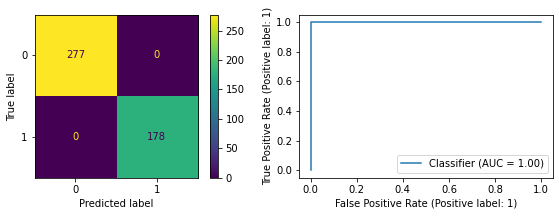

TEST ---------------------------------------------------------
Accuracy=0.9211, Precision=0.8824, Recall=0.8571, F1=0.8696


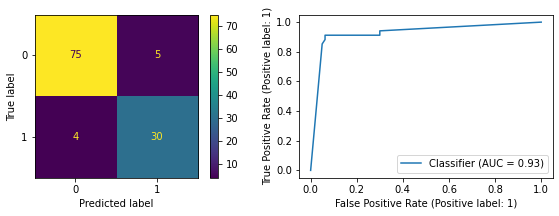

In [222]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

pca = PCA(n_components=10, random_state=4)
x_train = pd.DataFrame(pca.fit_transform(x_train))

bins = []
for c in x_train.columns:
    x_train[c], c_bins = pd.qcut(x_train[c], BEST_BIN_QCUT, retbins=True)
    bins.append(c_bins)

my_tree = DecisionTreeClassifier(positive_label=POS_LABEL, criterion='gini')
my_tree.fit(x_train.to_numpy(), y_train.to_numpy())

my_tree.plot_tree(list(x_train.columns), 'cancer_qcut_gini_pca')
my_tree.save_dict(list(x_train.columns), 'cancer_qcut_gini_pca')

x_test = pd.DataFrame(pca.transform(x_test))
for idx, c in enumerate(x_test.columns):
    x_test[c] = pd.cut(x_test[c], bins[idx])

print(f'TRAIN --------------------------------------------------------')
y_pred = my_tree.predict(x_train.to_numpy())
y_pred_prob = my_tree.predict_prob(x_train.to_numpy())
classification_evaluation(y_pred, y_train, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)

print(f'TEST ---------------------------------------------------------')
y_pred = my_tree.predict(x_test.to_numpy())
y_pred_prob = my_tree.predict_prob(x_test.to_numpy())
classification_evaluation(y_pred, y_test, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)

## Early stopping methods

### Using higher `min_sample_split` than 1

TRAIN with 1 min_sample_split --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


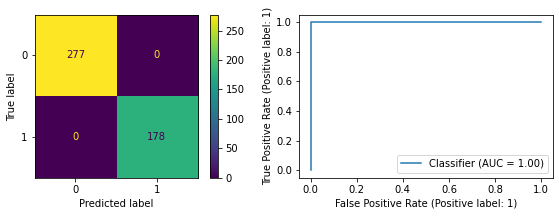

TEST with 1 min_sample_split ---------------------------------------------------------
Accuracy=0.9386, Precision=0.8824, Recall=0.9091, F1=0.8955


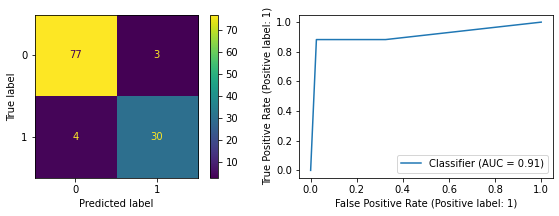

TRAIN with 2 min_sample_split --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


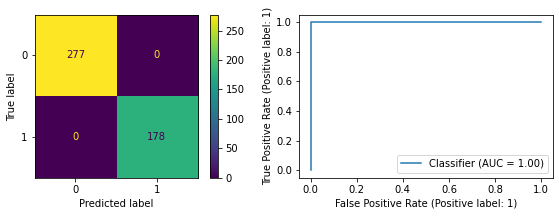

TEST with 2 min_sample_split ---------------------------------------------------------
Accuracy=0.9386, Precision=0.8824, Recall=0.9091, F1=0.8955


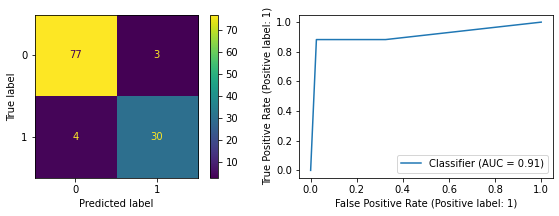

TRAIN with 3 min_sample_split --------------------------------------------------------
Accuracy=0.9978, Precision=0.9944, Recall=1.0, F1=0.9972


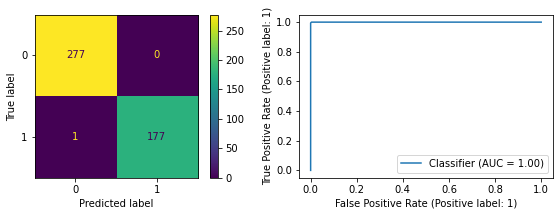

TEST with 3 min_sample_split ---------------------------------------------------------
Accuracy=0.9386, Precision=0.8824, Recall=0.9091, F1=0.8955


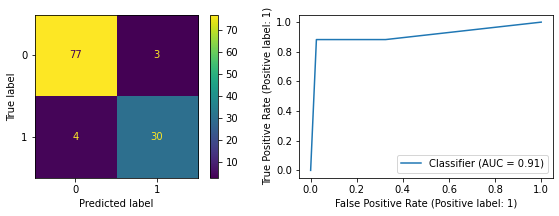

TRAIN with 5 min_sample_split --------------------------------------------------------
Accuracy=0.989, Precision=0.9775, Recall=0.9943, F1=0.9858


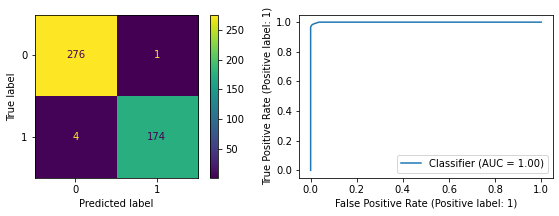

TEST with 5 min_sample_split ---------------------------------------------------------
Accuracy=0.9298, Precision=0.8824, Recall=0.8824, F1=0.8824


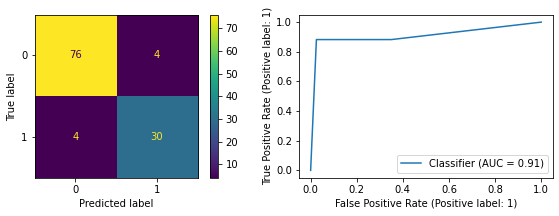

TRAIN with 10 min_sample_split --------------------------------------------------------
Accuracy=0.9714, Precision=0.9551, Recall=0.9714, F1=0.9632


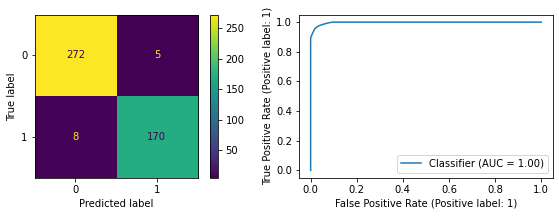

TEST with 10 min_sample_split ---------------------------------------------------------
Accuracy=0.9386, Precision=0.9412, Recall=0.8649, F1=0.9014


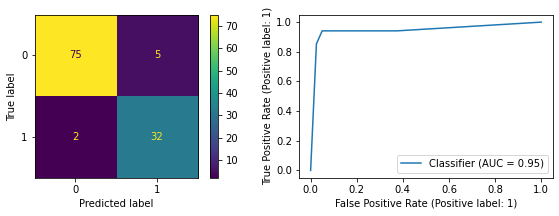

TRAIN with 20 min_sample_split --------------------------------------------------------
Accuracy=0.9714, Precision=0.9551, Recall=0.9714, F1=0.9632


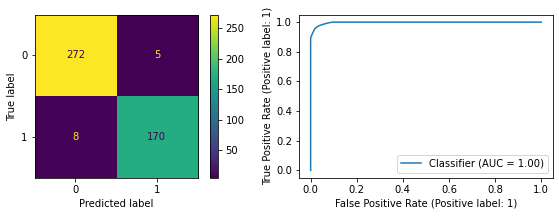

TEST with 20 min_sample_split ---------------------------------------------------------
Accuracy=0.9386, Precision=0.9412, Recall=0.8649, F1=0.9014


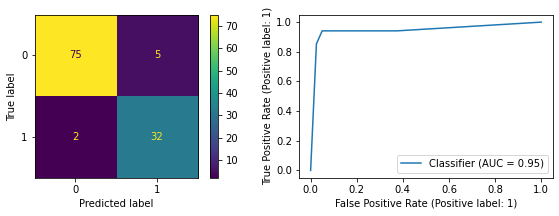

TRAIN with 50 min_sample_split --------------------------------------------------------
Accuracy=0.9341, Precision=0.9213, Recall=0.9111, F1=0.9162


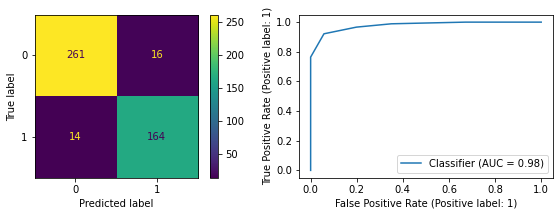

TEST with 50 min_sample_split ---------------------------------------------------------
Accuracy=0.8596, Precision=0.9118, Recall=0.7045, F1=0.7949


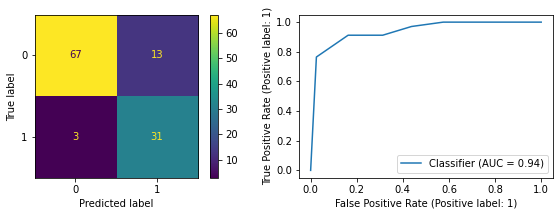

Maximum accuracy 0.9385964912280702 with 5 min_sample_split


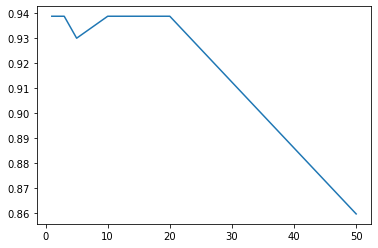

In [33]:
min_values = [1, 2, 3, 5, 10, 20, 50]
acc_history = []

for v in min_values:
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    bins = []
    for c in x_train.columns:
        x_train[c], c_bins = pd.qcut(x_train[c], BEST_BIN_QCUT, retbins=True)
        bins.append(c_bins)

    my_tree = DecisionTreeClassifier(positive_label=POS_LABEL, min_samples_split=v)
    my_tree.fit(x_train.to_numpy(), y_train.to_numpy())
    
    my_tree.plot_tree(list(x_train.columns), 'cancer_qcut_entropy'+str(v)+'minsplit')
    my_tree.save_dict(list(x_train.columns), 'cancer_qcut_entropy'+str(v)+'minsplit')
    
    for idx, c in enumerate(x_test.columns):
        x_test[c] = pd.cut(x_test[c], bins[idx])
        
    print(f'TRAIN with {v} min_sample_split --------------------------------------------------------')
    y_pred = my_tree.predict(x_train.to_numpy())
    y_pred_prob = my_tree.predict_prob(x_train.to_numpy())
    classification_evaluation(y_pred, y_train, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)
    
    print(f'TEST with {v} min_sample_split ---------------------------------------------------------')
    y_pred = my_tree.predict(x_test.to_numpy())
    y_pred_prob = my_tree.predict_prob(x_test.to_numpy())
    classification_evaluation(y_pred, y_test, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)
    acc_history.append(accuracy_score(y_pred, y_test.to_numpy()))
    
print(f'Maximum accuracy {np.max(acc_history)} with {values[np.argmax(acc_history)]} min_sample_split')
plt.plot(min_values, acc_history)

### Using lower `max_depth` than infinite

TRAIN with 1 max_depth --------------------------------------------------------
Accuracy=0.9341, Precision=0.9213, Recall=0.9111, F1=0.9162


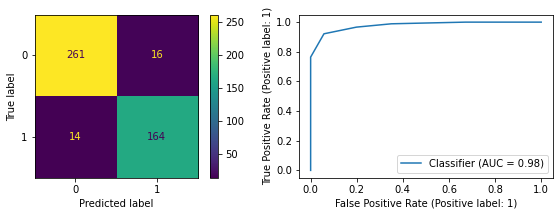

TEST with 1 max_depth ---------------------------------------------------------
Accuracy=0.8596, Precision=0.9118, Recall=0.7045, F1=0.7949


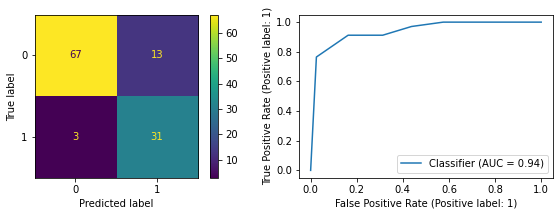

TRAIN with 2 max_depth --------------------------------------------------------
Accuracy=0.9714, Precision=0.9551, Recall=0.9714, F1=0.9632


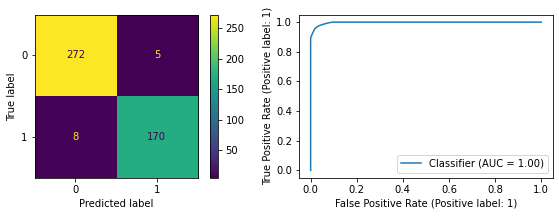

TEST with 2 max_depth ---------------------------------------------------------
Accuracy=0.9386, Precision=0.9412, Recall=0.8649, F1=0.9014


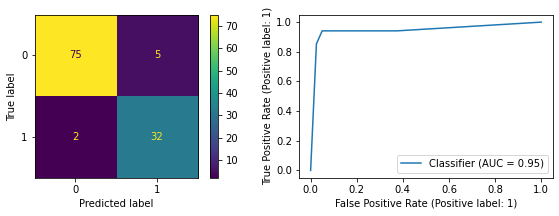

TRAIN with 3 max_depth --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


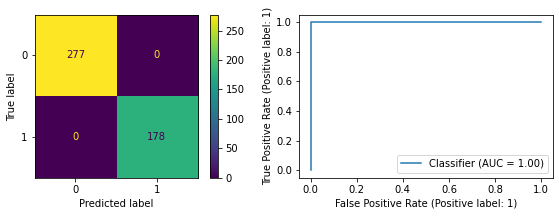

TEST with 3 max_depth ---------------------------------------------------------
Accuracy=0.9386, Precision=0.8824, Recall=0.9091, F1=0.8955


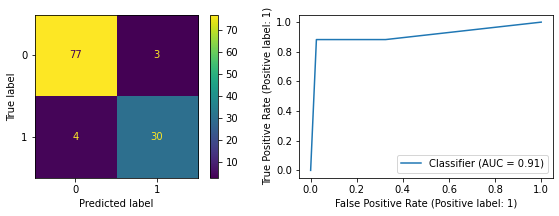

TRAIN with 4 max_depth --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


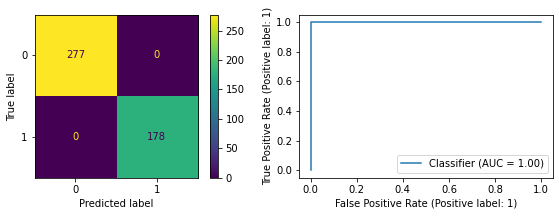

TEST with 4 max_depth ---------------------------------------------------------
Accuracy=0.9386, Precision=0.8824, Recall=0.9091, F1=0.8955


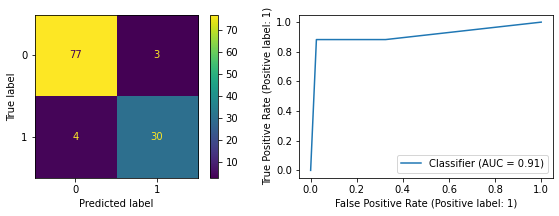

TRAIN with 5 max_depth --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


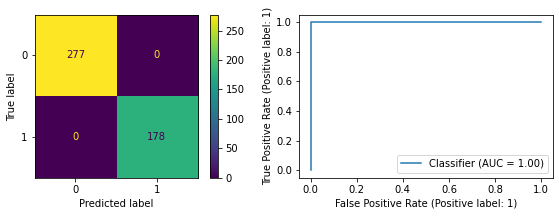

TEST with 5 max_depth ---------------------------------------------------------
Accuracy=0.9386, Precision=0.8824, Recall=0.9091, F1=0.8955


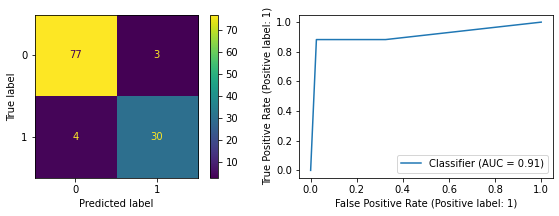

TRAIN with 6 max_depth --------------------------------------------------------
Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0


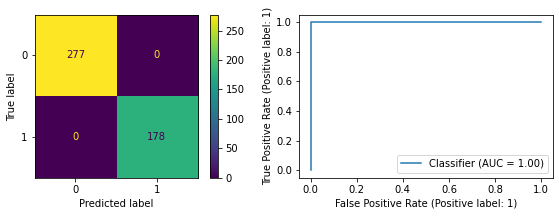

TEST with 6 max_depth ---------------------------------------------------------
Accuracy=0.9386, Precision=0.8824, Recall=0.9091, F1=0.8955


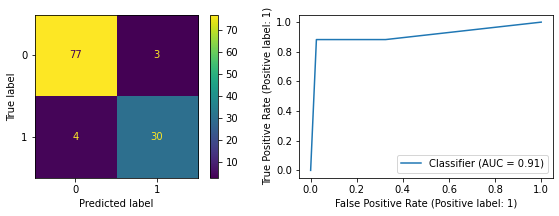

Maximum accuracy 0.9385964912280702 with 10 max_depth


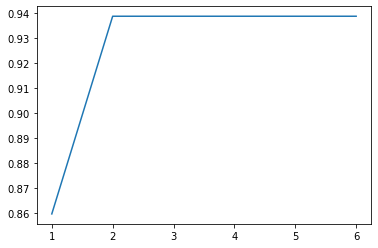

In [38]:
max_values = [1, 2, 3, 4, 5, 6]
acc_history = []

for v in max_values:
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    bins = []
    for c in x_train.columns:
        x_train[c], c_bins = pd.qcut(x_train[c], BEST_BIN_QCUT, retbins=True)
        bins.append(c_bins)

    my_tree = DecisionTreeClassifier(positive_label=POS_LABEL, max_depth=v)
    my_tree.fit(x_train.to_numpy(), y_train.to_numpy())
    
    my_tree.plot_tree(list(x_train.columns), 'cancer_qcut_entropy'+str(v)+'maxdepth')
    my_tree.save_dict(list(x_train.columns), 'cancer_qcut_entropy'+str(v)+'maxdepth')
    
    for idx, c in enumerate(x_test.columns):
        x_test[c] = pd.cut(x_test[c], bins[idx])
        
    print(f'TRAIN with {v} max_depth --------------------------------------------------------')
    y_pred = my_tree.predict(x_train.to_numpy())
    y_pred_prob = my_tree.predict_prob(x_train.to_numpy())
    classification_evaluation(y_pred, y_train, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)
    
    print(f'TEST with {v} max_depth ---------------------------------------------------------')
    y_pred = my_tree.predict(x_test.to_numpy())
    y_pred_prob = my_tree.predict_prob(x_test.to_numpy())
    classification_evaluation(y_pred, y_test, pos_label=POS_LABEL, y_pred_prob=y_pred_prob)
    acc_history.append(accuracy_score(y_pred, y_test.to_numpy()))
    
print(f'Maximum accuracy {np.max(acc_history)} with {values[np.argmax(acc_history)]} max_depth')
plt.plot(max_values, acc_history)

# Decision Tree Regressor

In [2]:
class RegressorNode:
    def __init__(self, feature=None, f_value=None, childs=None, value=None, most_common=None):
        # best feature to split the node
        self.feature = feature
        # value of parent's selected feature
        self.f_value = f_value
        # dictionary of childs
        self.childs = childs
        # value of the node if it is leaf
        self.value = value
        # most common value of the node
        self.most_common = most_common
        
    def is_leaf_node(self):
        return self.value is not None
    
    def plot_node(self, figure, column_labels):
        if self.childs is not None:
            for key in self.childs:
                if not self.childs[key].is_leaf_node():
                    figure.edge(str(column_labels[self.feature]), str(column_labels[self.childs[key].feature]))
                    self.childs[key].plot_node(figure, column_labels)
                else:
                    figure.attr('node', shape='box')
                    figure.edge(str(column_labels[self.feature]), str(self.childs[key].value), label=str(key))
                    figure.attr('node', shape='ellipse')
    
    def node_dict(self, column_labels):
        dict = {}
        if self.is_leaf_node():
            return str(self.value)
        else:
            for key in self.childs:
                dict[str((column_labels[self.feature], self.childs[key].f_value))] = self.childs[key].node_dict(column_labels)
        return dict

In [3]:
class DecisionTreeRegressor:
    def __init__(self, criterion='variance', min_samples_split=2, max_depth=float('inf'), decision_maker='mean'):
        # name of the criterion to select best splits
        self.criterion = criterion
        # minimum number of samples to consider it as leaf
        self.min_samples_split=min_samples_split
        # how to calculate value of the node
        self.decision_maker = decision_maker
        # maximum allowed depth for the tree
        self.max_depth = max_depth        
        # root of the tree
        self.root=None

    def fit(self, X, y, X_continuous=None):
        self.root = self._grow_tree(X, y, X_continuous)
    
    def plot_tree(self, column_labels, file_name):
        if not os.path.exists(FIGURES_PATH):
            os.mkdir(FIGURES_PATH)
        path = os.path.join(FIGURES_PATH, file_name)
        
        figure = graphviz.Digraph(file_name, filename=path)
        figure.attr('node', shape='ellipse')
        self.root.plot_node(figure, column_labels)
        figure.view()
    
    def save_dict(self, column_labels, file_name):
        dict = self.root.node_dict(column_labels)
        if not os.path.exists(DICTS_PATH):
            os.mkdir(DICTS_PATH)
        path = os.path.join(DICTS_PATH, file_name+'.txt')
        with open(path, 'w') as file:
            print(json.dumps(dict, indent=4), file=file)

    def _grow_tree(self, X, y, X_continuous, f_value=None, depth=0):
        n_samples, n_feats = X.shape
        # find the best split
        best_feature, best_vr = self._best_split(X, y)
        # check the stopping criteria
        if (n_samples < self.min_samples_split or best_vr == 0 or depth > self.max_depth):
            leaf_value = self._most_common_label(y, X_continuous)
            return RegressorNode(f_value=f_value, value=leaf_value, most_common=leaf_value)
        # create child nodes
        childs = {}
        best_feature_column = X[:, best_feature]
        for v in np.unique(best_feature_column):
            index = np.argwhere(best_feature_column == v).flatten()
            child_X = X[index]
            child_y = y[index]
            if self.decision_maker == 'linear':
                child_X_continuous = X_continuous[index]
                childs[v] = self._grow_tree(child_X, child_y, child_X_continuous, f_value=v, depth=depth+1)
            else:
                childs[v] = self._grow_tree(child_X, child_y, None, f_value=v, depth=depth+1)
        leaf_value = self._most_common_label(y, X_continuous)
        return RegressorNode(feature=best_feature, f_value=f_value, childs=childs, most_common=leaf_value)

    def _best_split(self, X, y):
        if self.criterion == 'variance':
            best_vr = -float('inf')
            split_idx = None
            for feat_idx in range(X.shape[1]):
                X_column = X[:, feat_idx]
                vr = self._variance_reduction(y, X_column)
                # print('feat_idx', feat_idx, 'vr', vr, 'best_vr', best_vr)
                if vr > best_vr:
                    best_vr = vr
                    split_idx = feat_idx
            return split_idx, best_vr
    
    def _variance_reduction(self, y, X_column):
        childs_idx = self._split(X_column)
        parent_var = np.var(y)
        for ch_id in childs_idx:
            parent_var -= (len(ch_id) / len(y)) * np.var(y[ch_id])
        return parent_var
        
    def _split(self, X_column):
        splits = []
        for v in np.unique(X_column):
            splits.append(np.argwhere(X_column == v).flatten())
        return splits
    
    def _most_common_label(self, y, X=None):
        if self.decision_maker == 'mean':
            return np.mean(y)
        elif self.decision_maker == 'median':
            return np.median(y)
        elif self.decision_maker == 'linear':
            lr = LinearRegression()
            lr.fit(X, y)
            return lr
        return None

    def predict(self, X, X_continuous=None):
        if self.decision_maker == 'linear':
            return np.array([self._traverse_tree(X[i], self.root, X_continuous[i]) for i in range(X.shape[0])])
        else:
            return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node, x_continuous=None):
        if node.is_leaf_node():
            if self.decision_maker == 'linear':
                return node.value.predict(x_continuous.reshape(1, -1))
            else:
                return node.value
        
        if x[node.feature] in node.childs:
            return self._traverse_tree(x, node.childs[x[node.feature]], x_continuous)
        else:
            if self.decision_maker == 'linear':
                return node.most_common.predict(x_continuous.reshape(1, -1))
            else:
                return node.most_common

In [4]:
def regression_evaluation(y_pred, y):
    print(f'MAE = {mean_absolute_error(y_pred, y)}, MSE = {mean_squared_error(y_pred, y)}')

## Car price dataset

In [40]:
df = pd.read_csv('part3.csv', index_col='ID')
df

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
ID,,,,,,,,,,,,,,,,,
45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45798355,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
45804997,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4


In [41]:
df.dtypes

Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object

### Considering `Turbo` as a separate feature from `Engine volume`

In [42]:
temp_df = df['Engine volume'].str.split(' ')
df['Engine volume'] = temp_df.apply(lambda a : a[0]).astype('float64')
df['Is turbo'] = temp_df.apply(lambda a: 'Yes' if len(a) > 1 else 'No')

### Removing `km` suffix from `Mileage` feature

In [43]:
df['Mileage'] = df['Mileage'].str.replace('km', '').astype('int64')

### Replacing missing values of `Levy` feature by it's mean 

In [44]:
levy_missed = df['Levy']
levy_not_missed = levy_missed[levy_missed != '-'].astype('int64')
mean_levy = round(levy_not_missed.mean())
levy_missed[levy_missed == '-'] = mean_levy
df['Levy'] = levy_missed.astype('int64')

C:\Users\Alireza\AppData\Local\Temp/ipykernel_13076/4126629337.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  levy_missed[levy_missed == '-'] = mean_levy


In [45]:
df.dtypes

Price                 int64
Levy                  int64
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume       float64
Mileage               int64
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
Is turbo             object
dtype: object

### Using `mean` of values as output

TRAIN with 5 bins ---------------------------------------------------------
MAE = 912.3992611067139, MSE = 10059329.720276494
TEST with 5 bins ----------------------------------------------------------
MAE = 7156.52157033862, MSE = 586204430.0981526

TRAIN with 10 bins ---------------------------------------------------------
MAE = 587.0283835207824, MSE = 6708965.796462534
TEST with 10 bins ----------------------------------------------------------
MAE = 7002.6677461581885, MSE = 588471805.8539686

TRAIN with 15 bins ---------------------------------------------------------
MAE = 477.5515787711009, MSE = 5412131.886472218
TEST with 15 bins ----------------------------------------------------------
MAE = 6189.824158662323, MSE = 176605740.69569343

TRAIN with 20 bins ---------------------------------------------------------
MAE = 453.1292261694673, MSE = 5362504.426767099
TEST with 20 bins ----------------------------------------------------------
MAE = 6209.294499933958, MSE = 1699138

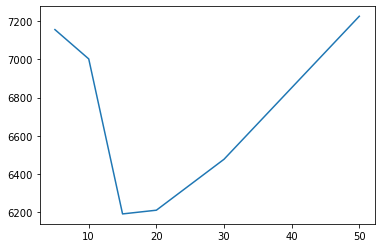

In [16]:
numerical_features = ['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']

values = [5, 10, 15, 20, 30, 50]
acc_history = []

for v in values:
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    bins = []
    for c in numerical_features:
        x_train[c], c_bins = pd.qcut(x_train[c], v, duplicates='drop', retbins=True)
        bins.append(c_bins)
    
    my_tree = DecisionTreeRegressor()
    my_tree.fit(x_train.to_numpy(), y_train.to_numpy())
    
#     my_tree.plot_tree(list(x_train.columns), 'carprice_mean_'+str(v)+'bin')
    my_tree.save_dict(list(x_train.columns), 'carprice_mean_'+str(v)+'bin')
    
    for idx, c in enumerate(numerical_features):
        x_test[c] = pd.cut(x_test[c], bins[idx])

    print(f'TRAIN with {v} bins ---------------------------------------------------------')
    y_pred = my_tree.predict(x_train.to_numpy())
    regression_evaluation(y_pred, y_train)
    print(f'TEST with {v} bins ----------------------------------------------------------')
    y_pred = my_tree.predict(x_test.to_numpy())
    regression_evaluation(y_pred, y_test)
    
    acc_history.append(mean_absolute_error(y_pred, y_test))
    print()
    
print(f'Minimum MAE {np.min(acc_history)} with {values[np.argmin(acc_history)]} bins')
plt.plot(values, acc_history)

### Using `median` of values as output

TRAIN with 5 bins ---------------------------------------------------------
MAE = 794.3501202157386, MSE = 13795545.800311912
TEST with 5 bins ----------------------------------------------------------
MAE = 6412.819386694387, MSE = 191967559.5822505

TRAIN with 10 bins ---------------------------------------------------------
MAE = 510.0786275911365, MSE = 8877139.048931055
TEST with 10 bins ----------------------------------------------------------
MAE = 6354.496231808732, MSE = 193318135.73694128

TRAIN with 15 bins ---------------------------------------------------------
MAE = 406.8318929105205, MSE = 7793228.121125479
TEST with 15 bins ----------------------------------------------------------
MAE = 6065.669048856549, MSE = 186459429.47680613

TRAIN with 20 bins ---------------------------------------------------------
MAE = 387.131067645721, MSE = 7715820.303788421
TEST with 20 bins ----------------------------------------------------------
MAE = 6056.162681912682, MSE = 1772509

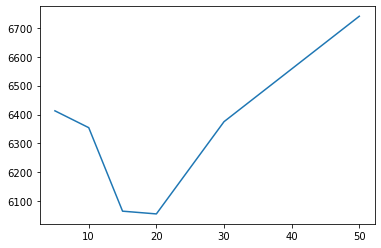

In [14]:
numerical_features = ['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']

values = [5, 10, 15, 20, 30, 50]
acc_history = []

for v in values:
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    bins = []
    for c in numerical_features:
        x_train[c], c_bins = pd.qcut(x_train[c], v, duplicates='drop', retbins=True)
        bins.append(c_bins)
    
    my_tree = DecisionTreeRegressor(decision_maker='median')
    my_tree.fit(x_train.to_numpy(), y_train.to_numpy())
    
#     my_tree.plot_tree(list(x_train.columns), 'carprice_median_'+str(v)+'bin')
    my_tree.save_dict(list(x_train.columns), 'carprice_median_'+str(v)+'bin')
    
    for idx, c in enumerate(numerical_features):
        x_test[c] = pd.cut(x_test[c], bins[idx])

    print(f'TRAIN with {v} bins ---------------------------------------------------------')
    y_pred = my_tree.predict(x_train.to_numpy())
    regression_evaluation(y_pred, y_train)
    print(f'TEST with {v} bins ----------------------------------------------------------')
    y_pred = my_tree.predict(x_test.to_numpy())
    regression_evaluation(y_pred, y_test)
    
    acc_history.append(mean_absolute_error(y_pred, y_test))
    print()
    
print(f'Minimum MAE {np.min(acc_history)} with {values[np.argmin(acc_history)]} bins')
plt.plot(values, acc_history)

### Using `linear` strategy which fits a line to the data

TRAIN with 5 bins ---------------------------------------------------------
MAE = 442.1284487552134, MSE = 5219420.807689213
TEST with 5 bins ----------------------------------------------------------
MAE = 13531.711544461343, MSE = 27270814926.469345

TRAIN with 10 bins ---------------------------------------------------------
MAE = 335.833464363125, MSE = 4585605.466235042
TEST with 10 bins ----------------------------------------------------------
MAE = 22004.068614085714, MSE = 264137326218.09628

TRAIN with 15 bins ---------------------------------------------------------
MAE = 284.0842634032175, MSE = 4035605.8999806982
TEST with 15 bins ----------------------------------------------------------
MAE = 23747.30934005876, MSE = 323211758591.2602

TRAIN with 20 bins ---------------------------------------------------------
MAE = 272.7069927746279, MSE = 3988644.96226633
TEST with 20 bins ----------------------------------------------------------
MAE = 39637.625434293106, MSE = 17152

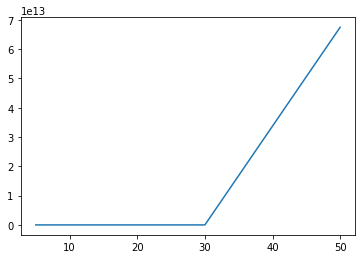

In [15]:
numerical_features = ['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']

values = [5, 10, 15, 20, 30, 50]
acc_history = []

for v in values:
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    x_train_continuous = x_train.copy()[numerical_features]
    x_test_continuous = x_test.copy()[numerical_features]
    bins = []
    for c in numerical_features:
        x_train[c], c_bins = pd.qcut(x_train[c], v, duplicates='drop', retbins=True)
        bins.append(c_bins)
    
    my_tree = DecisionTreeRegressor(decision_maker='linear')
    my_tree.fit(x_train.to_numpy(), y_train.to_numpy(), x_train_continuous.to_numpy())
        
#     my_tree.plot_tree(list(x_train.columns), 'carprice_linear_'+str(v)+'bin')
    my_tree.save_dict(list(x_train.columns), 'carprice_linear_'+str(v)+'bin')
    
    for idx, c in enumerate(numerical_features):
        x_test[c] = pd.cut(x_test[c], bins[idx])

    print(f'TRAIN with {v} bins ---------------------------------------------------------')
    y_pred = my_tree.predict(x_train.to_numpy(), x_train_continuous.to_numpy())
    regression_evaluation(y_pred, y_train)
    print(f'TEST with {v} bins ----------------------------------------------------------')
    y_pred = my_tree.predict(x_test.to_numpy(), x_test_continuous.to_numpy())
    regression_evaluation(y_pred, y_test)
    
    acc_history.append(mean_absolute_error(y_pred, y_test))
    print()
    
print(f'Minimum MAE {np.min(acc_history)} with {values[np.argmin(acc_history)]} bins')
plt.plot(values, acc_history)

## Sklearn Decision Tree Regressor

In [58]:
X = df.iloc[:, 1:].to_numpy()
y = df.iloc[:, 0].to_numpy()

les = []
for c in range(X.shape[1]):
    le = LabelEncoder()
    X[:, c] = le.fit_transform(X[:, c])
    les.append(le)


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

sk_tree = SkDecisionTreeRegressor(max_depth=5)
sk_tree.fit(x_train, y_train)

print(f'TRAIN ---------------------------------------------------------')
y_pred = sk_tree.predict(x_train)
regression_evaluation(y_pred, y_train)

print(f'TEST ----------------------------------------------------------')
y_pred = sk_tree.predict(x_test)
regression_evaluation(y_pred, y_test)

TRAIN ---------------------------------------------------------
MAE = 9552.730294115127, MSE = 260287373.5534996
TEST ----------------------------------------------------------
MAE = 16488.546895105304, MSE = 180034496042.84238
